# Imports

In [1]:
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ar_model import AutoReg

from tqdm import tqdm
from typing import Optional, Union

# Load data

## Futures

In [2]:
file_name = "./bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df_futures = table.to_pandas()

print(df_futures.head())

                               timestamp   open   high    low  close   volume  \
timestamp                                                                       
2022-10-01 00:00:00+00:00  1664582400000  5.406  5.406  5.401  5.403  20601.0   
2022-10-01 00:01:00+00:00  1664582460000  5.403  5.404  5.401  5.403   7417.0   
2022-10-01 00:02:00+00:00  1664582520000  5.403  5.407  5.403  5.407   4555.0   
2022-10-01 00:03:00+00:00  1664582580000  5.406  5.408  5.404  5.405  11194.0   
2022-10-01 00:04:00+00:00  1664582640000  5.404  5.406  5.404  5.405   1942.0   

                          exchange_id              knowledge_timestamp  \
timestamp                                                                
2022-10-01 00:00:00+00:00     binance 2022-10-02 00:17:30.835182+00:00   
2022-10-01 00:01:00+00:00     binance 2022-10-02 00:17:30.835182+00:00   
2022-10-01 00:02:00+00:00     binance 2022-10-02 00:17:30.835182+00:00   
2022-10-01 00:03:00+00:00     binance 2022-10-02 00:17:30.8351

In [3]:
print(df_futures.index.min())
print(df_futures.index.max())

2019-09-08 17:57:00+00:00
2023-01-31 23:59:00+00:00


In [4]:
currency_pairs = list(df_futures["currency_pair"].unique())
currency_pairs

['APE_USDT',
 'AVAX_USDT',
 'AXS_USDT',
 'BAKE_USDT',
 'BNB_USDT',
 'BTC_BUSD',
 'BTC_USDT',
 'CRV_USDT',
 'CTK_USDT',
 'DOGE_USDT',
 'DOT_USDT',
 'DYDX_USDT',
 'ETH_BUSD',
 'ETH_USDT',
 'FTM_USDT',
 'GMT_USDT',
 'LINK_USDT',
 'MATIC_USDT',
 'NEAR_USDT',
 'OGN_USDT',
 'RUNE_USDT',
 'SAND_USDT',
 'SOL_USDT',
 'STORJ_USDT',
 'UNFI_USDT',
 'WAVES_USDT',
 'XRP_USDT']

## RavenPack

In [5]:
# Crypto coins from the target currency pairs.
coins_to_rp_entity_ids = {
    "APE": "F1E044",
    "AVAX": "E05E4B",
    "AXS": "27EA56",
    "BAKE": "A339AD",
    "BNB": "A2BF5C",
    "BTC": "A25816",
    "BUSD": "FCB6D2",
    "CRV": "0B364F",
    "CTK": "EED9D1",
    "DOGE": "2070E1",
    "DOT": "AA8895",
    # "DYDX" - missing from RP
    "ETH": "0A2CF4",
    "FTM": "ECE804",
    "GMT": "5687B4",
    "LINK": "E7792B",
    "MATIC": "AB69E3",
    "NEAR": "87A7FA",
    "OGN": "32B6C7",
    "RUNE": "BA701C",
    "SAND": "F85EC6",
    "SOL": "BF05E7",
    "STORJ": "49749C",
    # "UNFI" - missing from RP
    "USDT": "9D4B6F",
    "WAVES": "1E4A65",
    "XRP": "547BE3"
}

In [6]:
# Loading data for the target coins from 2019-09-01 to 2023-02-10.
rp_data = pd.read_csv("rp_crypto_data_2019_2023.csv")
print(rp_data.shape)
rp_data.head()

(339302, 30)


,TIMESTAMP_UTC,RP_DOCUMENT_ID,RP_ENTITY_ID,ENTITY_TYPE,ENTITY_NAME,ENTITY_RELEVANCE,ENTITY_SENTIMENT,ENTITY_SENTIMENT_CONFIDENCE,ENTITY_TEXT_SENTIMENT,ENTITY_TEXT_SENT_CONFIDENCE,...,EVENT_SIMILARITY_KEY,EVENT_SIMILARITY_DAYS,EVENT_TEXT,DOCUMENT_SENTIMENT,DOCUMENT_SENTIMENT_CONFIDENCE,COMPOSITE_SENTIMENT_SCORE,SENTIMENT_IMPACT_PROJECTION,RP_SOURCE_ID,SOURCE_NAME,RP_PROVIDER_ID
0,2019-09-01 00:00:05.121,32A54FBA6E174C02A820D46D70DE5D23,A25816,CURR,Bitcoin,95,0.35,0.89,0.34,0.89,...,F9273CEF3D017257E1656C7E90310BD8,33.73147,"Bitcoin topped $11,000 in late June",0.37,0.91,0.00,-0.08,A1F054,Winsight Grocery Business,DJTP
1,2019-09-01 02:06:04.236,5E9AA7A7F6143BEB5964B66354D8C94C,A25816,CURR,Bitcoin,99,-0.16,0.39,-0.13,0.34,...,9A23D7DBD282D06E9F2CCC6AE44F8A86,0.00789,Bitcoin price drops to $63,-0.02,0.01,-0.06,-0.02,E98DD9,Bitcoin Exchange Guide,MRVR
2,2019-09-01 04:14:01.905,F5EC63F223BF3FEE0971AE703A2B28AD,A25816,CURR,Bitcoin,89,0.01,0.03,0.00,0.01,...,6728D145C445266BD3A642C836146D69,365.00000,Bitcoin gained 0.24% on Saturday,-0.07,0.16,0.04,-0.16,09DF84,FXEmpire,MRVR
3,2019-09-01 04:14:01.905,F5EC63F223BF3FEE0971AE703A2B28AD,A25816,CURR,Bitcoin,89,0.01,0.03,0.00,0.01,...,1C1E77614153B8DDBFD78E16AE57ADD5,0.28857,Bitcoin down by 4.6% for August,-0.07,0.16,0.04,-0.16,09DF84,FXEmpire,MRVR
4,2019-09-01 04:38:57.256,CDC75DBD92BD69742E0A9167E5A5D643,A25816,CURR,Bitcoin,99,0.15,0.38,0.15,0.38,...,1E771C128EAF606A1915899F9762ADDC,0.71383,"Btc is priced at $9,651.64",-0.02,0.07,0.00,-0.50,371A09,OurBitcoinNews.com,MRVR


In [7]:
rp_data["TIMESTAMP_UTC"] = pd.to_datetime(rp_data["TIMESTAMP_UTC"])
rp_data = rp_data.sort_values(by=["TIMESTAMP_UTC"])

# Add sentiment to futures data

In [8]:
def get_closest_sentiment(price_ts: pd.Timestamp, rp_data_coin: pd.DataFrame) -> Optional[float]:
    """
    Get the sentiment that was recorded earlier but closest in time to a given timestamp.

    :param price_ts: timestamp to search by
    :param rp_data_coin: RavenPack data for a certain coin
    :return: closest earlier sentiment value
    """
    pos = bisect.bisect_left(rp_data_coin["TIMESTAMP_UTC"].values, price_ts)
    if pos == 0:
        # The given timestamp is earlier than any of the sentiment timestamps.
        return None
    closest_sent = rp_data_coin["ENTITY_SENTIMENT"].iloc[pos-1]
    return closest_sent

### Case study --- APE_USDT

In [9]:
futures_data_with_sentiment = []
for target_pair in ["APE_USDT"]:
    print(target_pair)
    # Select RP data for the coin.
    target_coin = target_pair.split("_")[0]
    if target_coin not in coins_to_rp_entity_ids:
        # Skip coins that are not present in RP.
        print("Not present in RP; skipping.\n")
        continue
    coin_rp_ent_id = coins_to_rp_entity_ids[target_coin]
    rp_data_coin = rp_data[rp_data["RP_ENTITY_ID"] == coin_rp_ent_id]
    # Select futures data for the coin.
    df_pair = df_futures[df_futures["currency_pair"] == target_pair]
    # Add sentiment data to the futures data.
    # Every price point gets assigned a sentiment value of the event that
    # happened earlier but closest in time to it.
    sentiments = []
    for i in tqdm(range(len(df_pair))):
        sentiments.append(get_closest_sentiment(df_pair.index[i].tz_localize(None), rp_data_coin))
    df_pair = df_pair.assign(sentiment = sentiments)
    futures_data_with_sentiment.append(df_pair)

APE_USDT


100%|██████████| 461341/461341 [00:26<00:00, 17330.64it/s]


In [10]:
df_futures_with_sentiment = pd.concat(futures_data_with_sentiment)
df_futures_with_sentiment.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month,sentiment
timestamp,,,,,,,,,,,,
2022-10-01 00:00:00+00:00,1664582400000,5.406,5.406,5.401,5.403,20601.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10,0.39
2022-10-01 00:01:00+00:00,1664582460000,5.403,5.404,5.401,5.403,7417.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10,0.39
2022-10-01 00:02:00+00:00,1664582520000,5.403,5.407,5.403,5.407,4555.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10,0.39
2022-10-01 00:03:00+00:00,1664582580000,5.406,5.408,5.404,5.405,11194.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10,0.39
2022-10-01 00:04:00+00:00,1664582640000,5.404,5.406,5.404,5.405,1942.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10,0.39


# Build model

In [11]:
def compute_minutely_returns(df: pd.DataFrame) -> pd.Series:
    """
    Compute log returns on minutely prices data.
    
    :param df: dataframe with prices data
    :return: log returns
    """
    returns = np.log(df["close"]/df["close"].shift())
    res = pd.Series(returns, index=df.index)
    return res

def normalize_by_std(returns: pd.Series, window: str) -> pd.Series:
    """
    Normalize returns by rolling standard deviation.
    
    :param returns: returns to normalize
    :param window: a time window for std computation
    :return: normalized returns
    """
    # Compute the standard deviation in a rolling window.
    rolling_std = returns.rolling(window).std()
    # Normalize the returns data.
    returns_normalized = returns/rolling_std
    return returns_normalized    

def train_sentiment_regression_model(
    df_futures: pd.DataFrame,
    target_pair: str, 
    time_window_std: Union[str, int], 
    lags_returns: int,
    lags_residuals: int,
    lags_sentiment: int
) -> pd.DataFrame:
    """
    Fit and run a model that predicts price from sentiment.
    
    :param df_futures: futures data for crypto coins
    :param target_pair: a pair of currencies to select
    :param time_window_std: a time window for computing the rolling
        standard deviation of prices
    :param lags_returns: number of lags to predict returns with
    :param lags_residuals: number of lags to predict residuals with
    :param lags_sentiment: number of sentiment values to predict residuals with
    :return: futures data for the target currency pair with the added predicted 
        returns and residuals
    """
    df_pair = df_futures[df_futures["currency_pair"] == target_pair]
    df_pair = df_pair.sort_index()
    # Compute minutely returns for the currency pair.
    returns_coin = compute_minutely_returns(df_pair)
    # Normalize by rolling STD; time window is set to 3 days.
    returns_coin_normalized = normalize_by_std(returns_coin, window=time_window_std)
    df_pair = df_pair.assign(returns = returns_coin_normalized)
    df_pair.index = df_pair.index.to_period("min")
    df_pair = df_pair.dropna()
    # Fit and run an AR model to predict returns.
    ar_model = AutoReg(df_pair["returns"], lags=lags_returns).fit()
    returns_pred = ar_model.predict()
    df_pair = df_pair.assign(returns_pred = returns_pred)
    # Compute residuals.
    residual_values = df_pair["returns"] - returns_pred
    df_pair = df_pair.assign(residuals = residual_values)
    df_pair = df_pair.dropna()
    # Fit and run an ARDL model to predict residuals from sentiment.
    ardl_model = ARDL(
        df_pair["residuals"], 
        lags=lags_residuals, 
        exog=df_pair[["sentiment"]], 
        order=lags_sentiment
    ).fit()
    residuals_pred = ardl_model.predict()
    df_pair = df_pair.assign(residuals_pred = residuals_pred)
    df_pair = df_pair.dropna()
    return df_pair

In [12]:
target_pair = "APE_USDT"
df_pair = train_sentiment_regression_model(
    df_futures_with_sentiment,
    target_pair, 
    time_window_std="3D", 
    lags_returns=60,
    lags_residuals=60,
    lags_sentiment=1
)
mse_returns = mean_squared_error(df_pair["returns"], df_pair["returns_pred"])
mse_residuals = mean_squared_error(df_pair["residuals"], df_pair["residuals_pred"])
print(f"MSE for returns: {mse_returns}\nMSE for residuals: {mse_residuals}")

/home/sonniki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


MSE for returns: 1.0357258563382792
MSE for residuals: 1.035721589108166


In [13]:
df_pair

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month,sentiment,returns,returns_pred,residuals,residuals_pred
timestamp,,,,,,,,,,,,,,,,
2022-06-22 07:38,1655883480000,4.133,4.135,4.123,4.123,35439.0,binance,2022-07-09 23:22:18.241020+00:00,APE_USDT,2022,6,-0.47,-0.810085,-0.030258,-0.779827,0.003599
2022-06-22 07:39,1655883540000,4.124,4.125,4.111,4.113,48642.0,binance,2022-07-09 23:22:18.241020+00:00,APE_USDT,2022,6,-0.47,-0.811996,-0.066695,-0.745301,0.004219
2022-06-22 07:40,1655883600000,4.113,4.119,4.109,4.119,33530.0,binance,2022-07-09 23:22:18.241020+00:00,APE_USDT,2022,6,-0.47,0.487439,0.049780,0.437659,0.002756
2022-06-22 07:41,1655883660000,4.119,4.123,4.111,4.114,21599.0,binance,2022-07-09 23:22:18.241020+00:00,APE_USDT,2022,6,-0.47,-0.406183,0.031662,-0.437844,0.002473
2022-06-22 07:42,1655883720000,4.114,4.117,4.101,4.101,42069.0,binance,2022-07-09 23:22:18.241020+00:00,APE_USDT,2022,6,-0.47,-1.058251,0.007340,-1.065592,0.004357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:55,1675209300000,5.868,5.869,5.864,5.867,14535.0,binance,2023-02-01 00:17:37.849725+00:00,APE_USDT,2023,1,-0.50,0.000000,0.017231,-0.017231,0.002952
2023-01-31 23:56,1675209360000,5.866,5.866,5.858,5.858,13328.0,binance,2023-02-01 00:17:37.849725+00:00,APE_USDT,2023,1,-0.50,-1.216570,-0.050808,-1.165762,0.004657
2023-01-31 23:57,1675209420000,5.857,5.864,5.857,5.864,10989.0,binance,2023-02-01 00:17:37.849725+00:00,APE_USDT,2023,1,-0.50,0.811193,0.011796,0.799397,0.004238


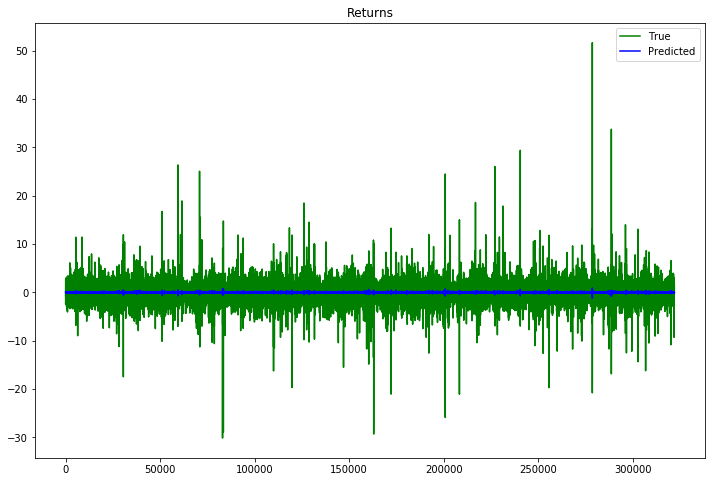

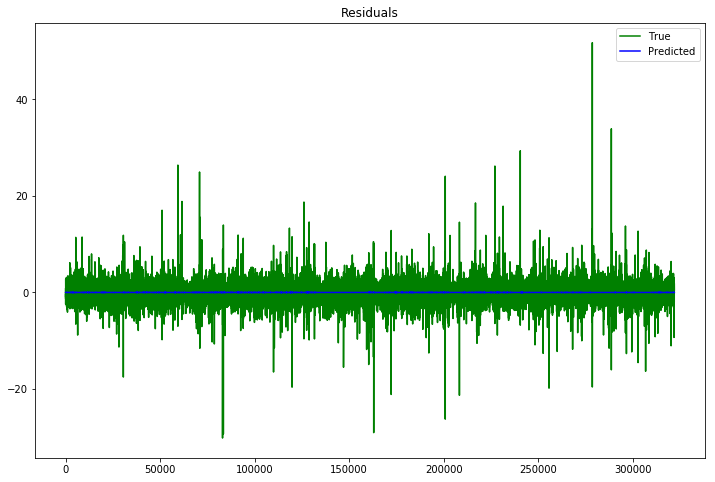

In [14]:
df_pair_plt = df_pair.reset_index(drop=True)
# Plot returns.
fig = plt.subplots(figsize=(12,8))
plt.plot(df_pair_plt["returns"], color="green", label="True")
plt.plot(df_pair_plt["returns_pred"], color="blue", label="Predicted")
plt.title("Returns")
plt.legend()
# Plot residuals.
fig = plt.subplots(figsize=(12,8))
plt.plot(df_pair_plt["residuals"], color="green", label="True")
plt.plot(df_pair_plt["residuals_pred"], color="blue", label="Predicted")
plt.title("Residuals")
plt.legend()
plt.show()